## 0.0 **Mount drive to datasets:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **0.1 Import libraries and set `DATA_PATH`:**

In [42]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from time import strftime
assert tf.__version__ >= "2.0"
import io
import itertools
from sklearn.metrics import classification_report

# autotune computation
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data directory
DATA_PATH = '/content/drive/MyDrive'

# Random seed:
RANDOM_SEED = 1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label'), plt.xlabel('Predicted label')


## **0.2 Paths to datasets:**

In [47]:
# Path to datasets:
# Full dataset (with all codecs)
dataset_name = 'tf_dataset_OtherWAV_small_highpass'
path_train = os.path.join(DATA_PATH, dataset_name, 'OtherWAV_train_set')
path_test = os.path.join(DATA_PATH, dataset_name, 'OtherWAV_test_set')

## **0.3 Read and show `config`:**


In [48]:
 # Read configs from dataset:
json_file_codec =  os.path.join(os.path.split(path_train)[0], 'DLNet_config.json')
with open(json_file_codec, "r") as read_file:
            config = json.load(read_file)
# Print Config:
print(json.dumps(config, sort_keys=False, indent=4))

{
    "audio_length": 1,
    "binary": false,
    "calculate_mel": false,
    "center": true,
    "classes": [
        "mp3_32k",
        "mp3_160k",
        "mp3_192k",
        "mp3_320k",
        "aac_128",
        "ogg_vbr",
        "uncompr_wav"
    ],
    "filter_config": [
        "high",
        4000
    ],
    "filter_signal": true,
    "hop_length": 256,
    "input_shape": [
        420,
        173,
        1
    ],
    "mono": true,
    "n_fft": 1024,
    "n_frames": 173,
    "n_mels": 64,
    "pad_mode": "reflect",
    "power": 2.0,
    "random_seed": 10,
    "sr": 44100,
    "time_stamp": "20_02_2021_14_42",
    "win_length": 512,
    "window": "hamm"
}


## **1.0 Load datasets:**
Print dataset info

In [74]:
# Load dataset:
# Codec1: (Compressed)
train_dataset = tf.data.experimental.load(path_train,
                        (tf.TensorSpec(config['input_shape'],
                                       dtype=tf.float32, name=None),
                         tf.TensorSpec(len(config['classes']),
                                       dtype=tf.uint8, name=None)),
                        compression='GZIP')
test_dataset = tf.data.experimental.load(path_test,
                        (tf.TensorSpec(config['input_shape'],
                                       dtype=tf.float32, name=None),
                         tf.TensorSpec(len(config['classes']),
                                       dtype=tf.uint8, name=None)),
                        compression='GZIP')

print(train_dataset)
print(f'Elements in dataset: {len(train_dataset)}')
print(test_dataset)
print(f'Elements in dataset: {len(test_dataset)}')


<_LoadDataset shapes: ((420, 173, 1), (7,)), types: (tf.float32, tf.uint8)>
Elements in dataset: 9800
<_LoadDataset shapes: ((420, 173, 1), (7,)), types: (tf.float32, tf.uint8)>
Elements in dataset: 2450


### 1.1 Prepare datasets:


*   Shuffle `train_dataset`
*   Take 10 % of `train_dataset` for evaluation: `eval_dataset`
*   Shuffle and batch rest of `train_dataset`
*   Batch `test_dataset`
*   Batch size: 64



In [75]:
train_size = len(train_dataset)
test_size = len(test_dataset)
eval_size = int(.1*train_size)
batch_size = 64

# Shuffel train data:
train_dataset = train_dataset.shuffle(buffer_size=train_size, seed=RANDOM_SEED)

# Split train into train and eval set:
eval_dataset = train_dataset.take(eval_size)
eval_dataset = eval_dataset.batch(batch_size).prefetch(AUTOTUNE)

# Train dataset
train_dataset = train_dataset.skip(eval_size)
train_dataset = train_dataset.shuffle(buffer_size=(train_size - eval_size),
                                      seed=RANDOM_SEED)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(AUTOTUNE)

# Prepare test dataset
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)


### 2.3 Callback Confusion Matrix

In [31]:
# Define metrics
metrics = [tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.FalseNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.CategoricalAccuracy()
           ]

In [76]:
# Load
trained_model = tf.keras.models.load_model(os.path.join(DATA_PATH, 'best_model_trained.h5'))
untrained_model = tf.keras.models.load_model(os.path.join(DATA_PATH, 'best_model.h5'))
# Summary
trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 420, 173, 1)       4         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 411, 170, 16)      656       
_________________________________________________________________
maxpool_layer1 (MaxPooling2D (None, 205, 85, 16)       0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 196, 82, 32)       20512     
_________________________________________________________________
maxpool_layer2 (MaxPooling2D (None, 98, 41, 32)        0         
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 89, 38, 32)        40992     
_________________________________________________________________
maxpool_layer3 (MaxPooling2D (None, 44, 19, 32)        0

## 7.0 Prediction

Classification report:
              precision    recall  f1-score   support

     mp3_32k       0.15      0.17      0.16      1270
    mp3_160k       0.14      0.16      0.15      1256
    mp3_192k       0.14      0.14      0.14      1273
    mp3_320k       0.14      0.14      0.14      1256
     aac_128       0.15      0.15      0.15      1259
     ogg_vbr       0.14      0.14      0.14      1256
 uncompr_wav       0.14      0.12      0.13      1250

    accuracy                           0.15      8820
   macro avg       0.15      0.15      0.15      8820
weighted avg       0.15      0.15      0.15      8820

------------------------------------------------:
Evaluate model on test dataset:
39/39 [==============================] - 16s 413ms/step - loss: 0.1363 - true_negatives_1: 14616.0000 - true_positives_1: 2361.0000 - false_negatives_1: 89.0000 - false_positives_1: 84.0000 - precision_1: 0.9656 - recall_1: 0.9637 - categorical_accuracy: 0.9641
------------------------------------

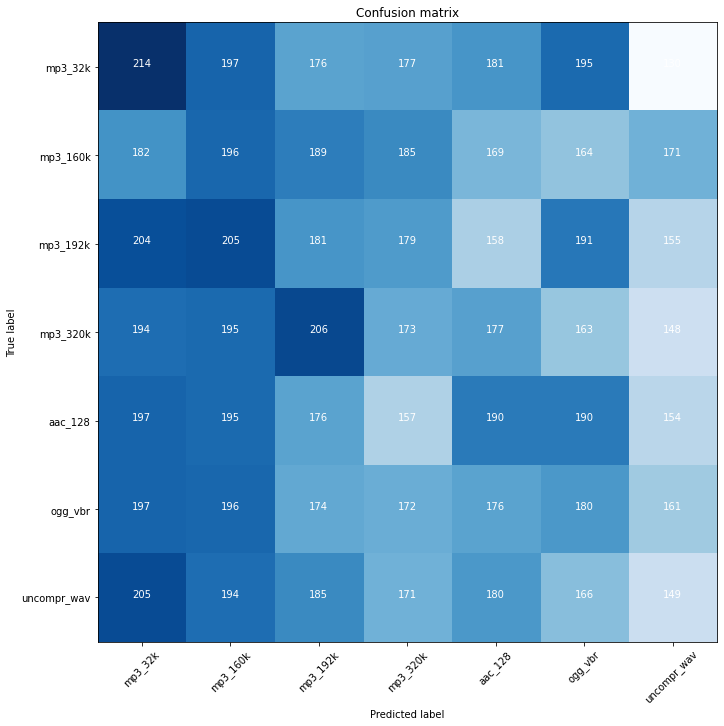

In [80]:
dataset = train_dataset.take(test_size)
y_train_prob = trained_model.predict(dataset, batch_size=batch_size)
y_train_pred = np.argmax(y_train_prob, axis=1)
y_train_true = np.argmax(np.array([y for x, y in dataset.unbatch().as_numpy_iterator()]), axis=1)

print('Classification report:')
print(classification_report(y_true=y_train_true, y_pred=y_train_pred, target_names=config['classes']))

print('------------------------------------------------:')
print('Evaluate model on test dataset:')
hist_eval = trained_model.evaluate(test_dataset)

print('------------------------------------------------:')
print('Evaluate model on eval dataset:')
hist_eval = trained_model.evaluate(eval_dataset)

# call confusion matrix
cm = tf.math.confusion_matrix(labels=y_train_true, predictions=y_train_pred)
cm = cm.numpy()
plot_confusion_matrix(cm, classes=config['classes'], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)

In [69]:
y_test_prob = model.predict(test_dataset, batch_size=batch_size)
y_test_pred = np.argmax(y_test_prob, axis=1)
y_test_true = np.argmax(np.array([y for x, y in test_dataset.unbatch().as_numpy_iterator()]), axis=1)


print('Classification report:')
print(classification_report(y_true=y_test_true, y_pred=y_test_pred, target_names=config['classes']))

print('------------------------------------------------:')
print('Evaluate model on test dataset:')
hist_eval = model.evaluate(test_dataset)

print('------------------------------------------------:')
print('Evaluate model on eval dataset:')
hist_eval = model.evaluate(eval_dataset)


KeyboardInterrupt: ignored

Confusion matrix, without normalization


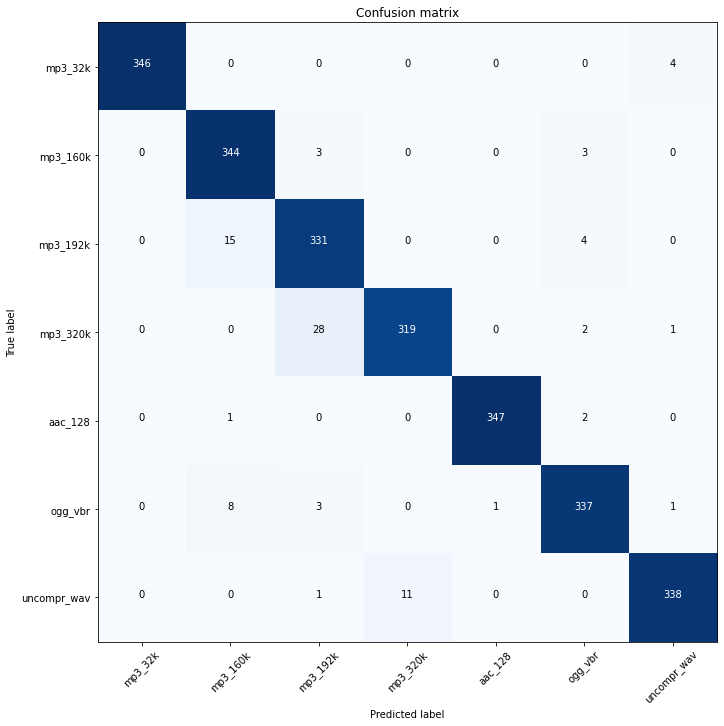

In [68]:
# call confusion matrix
cm = tf.math.confusion_matrix(labels=y_test_true, predictions=y_test_pred)
cm = cm.numpy()
plot_confusion_matrix(cm, classes=config['classes'], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)